# Pakete importieren

In [2]:
from datetime import datetime

import os
import glob
import numpy as np
import nibabel as nib
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

#preprocessing imports
import SimpleITK as sitk
from skimage import exposure
from tqdm import tqdm
import random

# evaluation imports
import re
from medpy.metric.binary import dc, hd95
from medpy.metric import binary
from scipy import ndimage as ndi

# Konfiguration der Pfade und Modelle

### Laufparameter

In [3]:
# === Experiment Management ===
# Aktuelles Datum im Format YYYYMMDD
#today = datetime.today().strftime("%Y%m%d")
today = "20251115"  # festsetzen für Reproduzierbarkeit

# Laufnummer manuell setzen (z. B. 01, 02, ...)
run_id = "01"   # anpassen bei jedem Lauf

# Kombinierter Laufname
run_name = f"run_{today}_{run_id}"

print(f"🔹 Aktueller Lauf: {run_name}")

🔹 Aktueller Lauf: run_20251115_01


### Verwendete Modelle

In [4]:
# Liste deiner Modelle (für Auswertung & Konsistenzprüfung)
MODEL_NAMES = [
    "nnUNetCADA",
    #  "nnUNetCADAneurisk",
   # "nnUNetCADA_wPostproc",
    #"nnUNetCADAneurisk_wPostproc",
    #  "VAsegmentation"
]

### Preprocessing konfigurieren

In [5]:
DO_PREPROCESSING = False

# --- Parameters ---
#target_spacing = (0.35, 0.35, 0.35)  # mm
#patch_size = (64, 64, 64)  # voxels

### Pfad konfiguration

In [6]:
DATA_DIR = "data_aneurisk"
ORIG_DIR = os.path.join(DATA_DIR, "original")
PP_DIR = os.path.join(DATA_DIR, "preprocessed")
PRED_DIR = os.path.join(DATA_DIR, "predictions")
GT_DIR = os.path.join(DATA_DIR, "GroundTruth")
GT_PP_DIR = os.path.join(DATA_DIR, "GroundTruth_preprocessed")

# Daten checken

### Hilfsfunktionen

In [7]:
def get_basename(filepath):
    """
    Entfernt .nii oder .nii.gz und schneidet beim ersten Unterstrich ab.
    Beispiel:
      'C0001_LPS-[np.int64(2004)].nii.gz' -> 'C0001'
      'C0039_LPS-[0].nii.gz' -> 'C0039'
      'C0012.nii' -> 'C0012'
    """
    filename = os.path.basename(filepath)
    if filename.endswith(".nii.gz"):
        filename = filename[:-7]
    elif filename.endswith(".nii"):
        filename = filename[:-4]
    
    # Nur bis zum ersten Unterstrich behalten
    if "_" in filename:
        filename = filename.split("_")[0]
    
    return filename

In [8]:

def check_pairs(original_dir=ORIG_DIR, gt_dir=GT_DIR):
    # Alle Dateien finden
    orig_files = sorted(glob.glob(os.path.join(original_dir, "*.nii")) +
                        glob.glob(os.path.join(original_dir, "*.nii.gz")))
    gt_files = sorted(glob.glob(os.path.join(gt_dir, "*.nii")) +
                      glob.glob(os.path.join(gt_dir, "*.nii.gz")))

    # Basenames ohne Endung
    orig_basenames = {get_basename(f) for f in orig_files}
    gt_basenames = {get_basename(f) for f in gt_files}

    # Paare
    paired = orig_basenames & gt_basenames
    only_orig = orig_basenames - gt_basenames
    only_gt = gt_basenames - orig_basenames

    print("===== Datensatz-Überprüfung =====")
    print(f"Anzahl Originaldateien: {len(orig_basenames)}")
    print(f"Anzahl GT-Dateien:       {len(gt_basenames)}")
    print(f"Gefundene Paare:         {len(paired)}")
    print(f"Nur Original, keine GT:  {len(only_orig)}")
    print(f"Nur GT, kein Original:   {len(only_gt)}")

    if only_orig:
        print("\nBeispiele ohne GT:")
        for name in list(sorted(only_orig))[:10]:
            print("  -", name)
        if len(only_orig) > 10:
            print("  ...")

    if only_gt:
        print("\nBeispiele ohne Original:")
        for name in list(sorted(only_gt))[:10]:
            print("  -", name)
        if len(only_gt) > 10:
            print("  ...")

    return {
        "paired": paired,
        "only_orig": only_orig,
        "only_gt": only_gt,
        "n_orig": len(orig_basenames),
        "n_gt": len(gt_basenames),
        "n_paired": len(paired)
    }

### Data check execution

In [9]:
# Aufrufen
pair_info = check_pairs()

===== Datensatz-Überprüfung =====
Anzahl Originaldateien: 23
Anzahl GT-Dateien:       23
Gefundene Paare:         23
Nur Original, keine GT:  0
Nur GT, kein Original:   0


# Preprocessing

| Schritt                           | Im Skript enthalten?                | Empfehlung                               |
| --------------------------------- | ----------------------------------- | ---------------------------------------- |
| **Resampling auf 0.35 mm**        | ❌ Nein                              | **Beibehalten in deinem Preprocessing!** |
| **Histogram Equalization**        | ✅ Ja (`HistogramEqualization(img)`) | **Weglassen**, sonst doppelt             |
| **Intensity Normalization [0–1]** | ✅ Ja (zweimal)                      | **Weglassen**, doppelt                   |
| **Cropping mit GT**               | ❌ Nein                              | **Weglassen bei Inference**              |
| **Padding auf 64er Blöcke**       | ✅ Ja (automatisch im Skript)        | **nicht anfassen**                       |


 ## Parameter festlegen

In [12]:
#siehe konfiguration

## Funktionen für Preprocessing

In [13]:
def resample_image(img, spacing, target_spacing):
    """Resample 3D image to the desired voxel spacing."""
    resampler = sitk.ResampleImageFilter()
    resampler.SetInterpolator(sitk.sitkLinear)
    resampler.SetOutputSpacing(target_spacing)
    resampler.SetOutputPixelType(sitk.sitkFloat32)  # <<<<< WICHTIG!

    orig_size = np.array(img.GetSize(), dtype=int)
    orig_spacing = np.array(spacing)
    new_size = np.round(orig_size * (orig_spacing / np.array(target_spacing))).astype(int)
    resampler.SetSize([int(x) for x in new_size])

    # Richtung und Ursprung übernehmen
    resampler.SetOutputOrigin(img.GetOrigin())
    resampler.SetOutputDirection(img.GetDirection())

    resampled_img = resampler.Execute(img)
    return resampled_img

def histogram_equalization(volume):
    """Histogramm-Equalization mit korrekter Normalisierung."""
    volume = volume.astype(np.float32)
    v_min, v_max = volume.min(), volume.max()
    if v_max - v_min > 0:
        volume = (volume - v_min) / (v_max - v_min)
    else:
        return volume
    volume_eq = exposure.equalize_hist(volume)
    return volume_eq

def normalize_intensity(volume):
    """Normalize voxel intensities to [0, 1]."""
    v_min, v_max = np.percentile(volume, (0.5, 99.5))
    if v_max - v_min < 1e-8:
        return np.zeros_like(volume)
    volume = np.clip(volume, v_min, v_max)
    norm = (volume - v_min) / (v_max - v_min)
    return norm

def crop_to_mask(img_array, mask_array, margin=5):
    """Crop to bounding box enclosing the labeled structure."""
    coords = np.argwhere(mask_array > 0)
    if coords.size == 0:
        return img_array, mask_array  # nothing to crop
    min_coords = np.maximum(coords.min(axis=0) - margin, 0)
    max_coords = np.minimum(coords.max(axis=0) + margin, img_array.shape)
    slices = tuple(slice(min_coords[i], max_coords[i]) for i in range(3))
    return img_array[slices], mask_array[slices]

In [14]:
def run_preprocessing(orig_dir=ORIG_DIR, out_dir=PP_DIR, target_spacing=(0.35, 0.35, 0.35)):
    """
    Führt das Preprocessing (Resampling) für ALLE .nii oder .nii.gz-Dateien im Ordner orig_dir durch.
    - Kein GT nötig
    - Kein Histogramm Equalization oder Normalisierung
    - Nur Resampling auf target_spacing (z. B. 0.35 mm isotrop)
    
    Ergebnisse werden im Ordner out_dir gespeichert.
    """
    os.makedirs(out_dir, exist_ok=True)

    # Alle NIfTI-Dateien im Eingabeordner finden
    all_files = sorted([
        f for f in os.listdir(orig_dir)
        if f.endswith(".nii.gz") or f.endswith(".nii")
    ])

    print(f"🔹 {len(all_files)} Dateien gefunden in {orig_dir}")

    for fname in tqdm(all_files):
        base = fname.replace(".nii.gz", "").replace(".nii", "")
        orig_path = os.path.join(orig_dir, fname)

        print(f"\n===== {base} =====")

        # --- Bild laden ---
        img = sitk.ReadImage(orig_path)
        spacing = img.GetSpacing()

        # --- Resample (Linear Interpolation) ---
        resampler = sitk.ResampleImageFilter()
        resampler.SetInterpolator(sitk.sitkLinear)
        resampler.SetOutputSpacing(target_spacing)
        resampler.SetOutputPixelType(sitk.sitkFloat32)
        resampler.SetOutputOrigin(img.GetOrigin())
        resampler.SetOutputDirection(img.GetDirection())

        # --- Neue Größe berechnen ---
        orig_size = np.array(img.GetSize(), dtype=int)
        orig_spacing = np.array(spacing)
        new_size = np.round(orig_size * (orig_spacing / np.array(target_spacing))).astype(int)
        resampler.SetSize([int(x) for x in new_size])

        # --- Resampling ausführen ---
        img_res = resampler.Execute(img)
        
#         # # --- Zu NumPy konvertieren ---
#         # img_arr = sitk.GetArrayFromImage(img_res)

#         # # --- Histogramm Equalization + Normalisierung ---
#         # img_arr = histogram_equalization(img_arr)
#         # img_arr = normalize_intensity(img_arr)

#         # # --- Speichern ---
#         # img_out = sitk.GetImageFromArray(img_arr.astype(np.float32))
#         # img_out.SetSpacing(target_spacing)
#         # img_out.SetOrigin(img_res.GetOrigin())

#         out_img_path = os.path.join(out_dir, base + ".nii.gz")
#         sitk.WriteImage(img_out, out_img_path)

        # --- Speichern ---
        out_img_path = os.path.join(out_dir, base + ".nii.gz")
        sitk.WriteImage(img_res, out_img_path)

        print(f"  ➤ Shape: {img_res.GetSize()}, Spacing: {img_res.GetSpacing()}")

    print(f"\n✅ Resampling abgeschlossen (Spacing = {target_spacing} mm). Dateien gespeichert in: {out_dir}")

## Preprocessing ausführen

In [15]:
if DO_PREPROCESSING:
    run_preprocessing()

## Preprocessing Überprüfen


🎲 Zufälliger Fall: C0075
Original:
  Path:     data/original/C0075_LPS.nii.gz
  Shape:    (256, 256, 256)
  Spacing:  (0.25856998562812805, 0.25856998562812805, 0.25856998562812805)
  Intensity range: 0.00 – 65535.00

Preprocessed:
  Path:     data/preprocessed/C0075_LPS.nii.gz
  Shape:    (189, 189, 189)
  Spacing:  (0.3499999940395355, 0.3499999940395355, 0.3499999940395355)
  Intensity range: 0.00 – 1.00


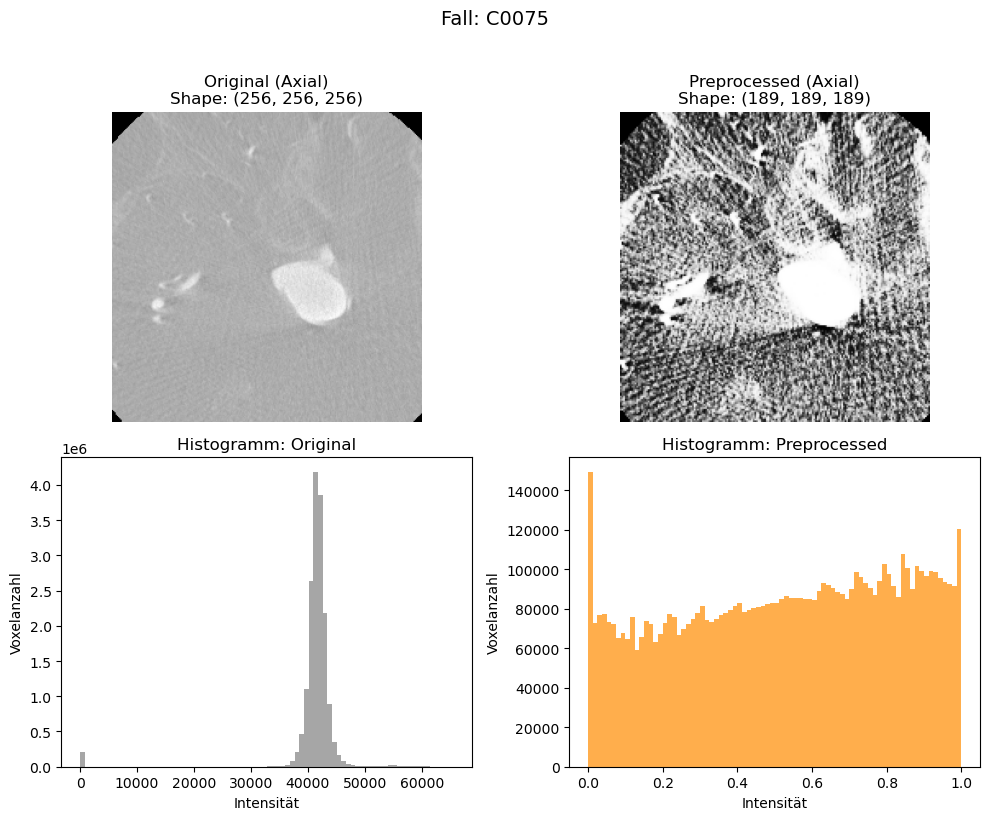

In [16]:
def show_random_case_info(orig_dir=ORIG_DIR, pp_dir=PP_DIR, paired_basenames=None):
    """
    Zeigt ein zufälliges Originalbild und das dazugehörige Preprocessed-Bild
    nebeneinander an + Histogrammvergleich + Metadaten.
    Verwendet get_basename(), um Dateien zu matchen (z. B. A001_orig <-> A001_gt_pp).
    """

    # Falls keine Basenames übergeben wurden → automatisch aus Originaldateien bestimmen
    if not paired_basenames:
        all_files = [f for f in os.listdir(orig_dir) if f.endswith(".nii.gz") or f.endswith(".nii")]
        paired_basenames = sorted(set(get_basename(f) for f in all_files))

    if not paired_basenames:
        print("⚠️ Keine passenden Dateien gefunden.")
        return

    # Zufälligen Fall auswählen
    base = random.choice(paired_basenames)
    print(f"\n🎲 Zufälliger Fall: {base}")

    # Originaldatei suchen
    orig_candidates = [
        f for f in os.listdir(orig_dir)
        if get_basename(f) == base and (f.endswith(".nii.gz") or f.endswith(".nii"))
    ]
    if not orig_candidates:
        print(f"⚠️ Kein Originalbild gefunden für {base}")
        return
    orig_path = os.path.join(orig_dir, orig_candidates[0])

    # Preprocessed-Datei suchen
    pp_candidates = [
        f for f in os.listdir(pp_dir)
        if get_basename(f) == base and (f.endswith(".nii.gz") or f.endswith(".nii"))
    ]
    if not pp_candidates:
        print(f"⚠️ Kein Preprocessed-Bild gefunden für {base}")
        return
    pp_path = os.path.join(pp_dir, pp_candidates[0])

    # --- Laden der Bilder ---
    orig_img = sitk.ReadImage(orig_path)
    pp_img = sitk.ReadImage(pp_path)
    orig_arr = sitk.GetArrayFromImage(orig_img)
    pp_arr = sitk.GetArrayFromImage(pp_img)

    # --- Metadaten ---
    print("Original:")
    print(f"  Path:     {orig_path}")
    print(f"  Shape:    {orig_arr.shape}")
    print(f"  Spacing:  {orig_img.GetSpacing()}")
    print(f"  Intensity range: {orig_arr.min():.2f} – {orig_arr.max():.2f}")
    print()
    print("Preprocessed:")
    print(f"  Path:     {pp_path}")
    print(f"  Shape:    {pp_arr.shape}")
    print(f"  Spacing:  {pp_img.GetSpacing()}")
    print(f"  Intensity range: {pp_arr.min():.2f} – {pp_arr.max():.2f}")

    # --- Slice indices individuell pro Array bestimmen ---
    slice_orig = orig_arr.shape[0] // 2
    slice_pp = pp_arr.shape[0] // 2

    # 2 Zeilen × 2 Spalten (oben Bilder, unten Histogramme)
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))

    # 1️⃣ Originalbild
    axes[0, 0].imshow(orig_arr[slice_orig, :, :], cmap="gray")
    axes[0, 0].set_title(f"Original (Axial)\nShape: {orig_arr.shape}")
    axes[0, 0].axis("off")

    # 2️⃣ Preprocessed-Bild
    axes[0, 1].imshow(pp_arr[slice_pp, :, :], cmap="gray")
    axes[0, 1].set_title(f"Preprocessed (Axial)\nShape: {pp_arr.shape}")
    axes[0, 1].axis("off")

    # 3️⃣ Histogramm Original
    axes[1, 0].hist(orig_arr.flatten(), bins=80, color="gray", alpha=0.7)
    axes[1, 0].set_title("Histogramm: Original")
    axes[1, 0].set_xlabel("Intensität")
    axes[1, 0].set_ylabel("Voxelanzahl")

    # 4️⃣ Histogramm Preprocessed
    axes[1, 1].hist(pp_arr.flatten(), bins=80, color="darkorange", alpha=0.7)
    axes[1, 1].set_title("Histogramm: Preprocessed")
    axes[1, 1].set_xlabel("Intensität")
    axes[1, 1].set_ylabel("Voxelanzahl")

    plt.suptitle(f"Fall: {base}", fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()
    
# --- Aufrufen ---
show_random_case_info()

# Inference

In [10]:
# Ordner für jedes Modell und den aktuellen Lauf anlegen
for model in MODEL_NAMES:
    model_dir = os.path.join(PRED_DIR, f"{model}_{run_name}")
    os.makedirs(model_dir, exist_ok=True)
    print(f"📁 Prediction-Ordner erstellt: {model_dir}")

📁 Prediction-Ordner erstellt: data_aneurisk/predictions/nnUNetCADA_run_20251115_01


Inferece run wird extern im cluster ausgeführt und das Ergebnis muss dann in die erstellten Ordner kopiert werden.
Danach kann die Evaluation ausgeführt werden.

# Evaluation

## Funktionen für die Evaluation

In [11]:
def get_base_name(fname):
    """
    Entfernt alles nach dem ersten Unterstrich (_) sowie
    Suffixe wie '-[np.int64(2004)]' oder '-[0]' aus Dateinamen.
    
    Beispiel:
      'C0001_LPS-[np.int64(2004)].nii.gz' -> 'C0001'
      'A001_orig.nii.gz' -> 'A001'
    """
    # Entferne Dateiendungen
    base = fname.replace(".nii.gz", "").replace(".nii", "")
    # Alles nach erstem Unterstrich abschneiden
    base = base.split("_")[0]
    return base

In [12]:
def load_nifti(path):
    return nib.load(path).get_fdata().astype(np.uint8)

In [13]:
def jaccard_index(pred_mask, gt_mask):
    """Intersection over Union (Jaccard Index)."""
    intersection = np.logical_and(pred_mask, gt_mask).sum()
    union = np.logical_or(pred_mask, gt_mask).sum()
    return intersection / union if union > 0 else np.nan

In [14]:
def connected_components(mask):
    """Return list of connected components (binary masks)."""
    labeled, n = ndi.label(mask)
    return [(labeled == i) for i in range(1, n+1) if (labeled == i).sum() > 0]


# def iou(mask_a, mask_b):
#     """Intersection over Union for two binary masks."""
#     inter = np.logical_and(mask_a, mask_b).sum()
#     union = np.logical_or(mask_a, mask_b).sum()
#     return inter / union if union > 0 else 0.0

  ### Greedy Matching
"Greedy" bedeutet:  
→ Es wird wiederholt das **BESTE noch verfügbare Paar** (GT_i, Pred_j)  
   mit dem **höchsten IoU-Wert** ausgwählt.


**Vorgehen**
1. Finde den **größten IoU** in der Matrix  
2. Wenn **IoU ≥ threshold** → Match  
3. Danach wird die ganze **GT-Reihe** UND **Pred-Spalte** gesperrt (auf −1 gesetzt)  
   → dieses Objekt wird **nicht erneut gematcht**  
4. Wiederholen…


**Ergebnis**
- Jeder **GT** kann höchstens **1 Pred** matchen  
- Jeder **Pred** kann höchstens **1 GT** matchen  


In [15]:
def match_objects(pred_objs, gt_objs, iou_threshold=0.30):
    """
    Match predicted and ground-truth aneurysm objects using IoU and return
    lesion-wise metrics (Dice, HD95, Jaccard) for TP matches.

    Returns:
        TP, FP, FN,
        matches: list of (gi, pi, iou, dice, hd, jac, vs)
        fp_list: list of (pi, best_iou)
        fn_list: list of (gi, best_iou)
    """
    # Sonderfälle
    if len(gt_objs) == 0 and len(pred_objs) == 0:
        return 0, 0, 0, [], [], []
    if len(gt_objs) == 0:
        fp_list = [(pi, 0.0) for pi in range(len(pred_objs))]
        return 0, len(pred_objs), 0, [], fp_list, []
    if len(pred_objs) == 0:
        fn_list = [(gi, 0.0) for gi in range(len(gt_objs))]
        return 0, 0, len(gt_objs), [], [], fn_list

    # IoU Matrix
    iou_mat = np.zeros((len(gt_objs), len(pred_objs)))
    for gi, g in enumerate(gt_objs):
        for pi, p in enumerate(pred_objs):
            iou_mat[gi, pi] = jaccard_index(g, p)

    matched_gt, matched_pred = set(), set()
    tp = 0
    matches = []

    # Greedy Matching
    iou_copy = iou_mat.copy()
    while True:
        gi, pi = np.unravel_index(np.argmax(iou_copy), iou_copy.shape)
        max_iou = iou_copy[gi, pi]

        # Abbruchbedingung: bestes Paar zu schlecht
        if max_iou < iou_threshold:
            break

        g_obj = gt_objs[gi]
        p_obj = pred_objs[pi]

        # lesion-wise voxel metrics
        l_dice = dc(p_obj, g_obj)
        try:
            l_hd = hd95(p_obj, g_obj)
        except Exception:
            l_hd = np.nan
        l_jac = jaccard_index(p_obj, g_obj)

        matches.append((gi, pi, float(max_iou), l_dice, l_hd, l_jac))
        tp += 1

        matched_gt.add(gi)
        matched_pred.add(pi)

        iou_copy[gi, :] = -1
        iou_copy[:, pi] = -1

    # FP: predicted objects without GT match
    fp_list = []
    for pi in range(len(pred_objs)):
        if pi not in matched_pred:
            best_iou = np.max(iou_mat[:, pi]) if iou_mat[:, pi].size > 0 else 0.0
            fp_list.append((pi, float(best_iou)))

    # FN: GT objects without match
    fn_list = []
    for gi in range(len(gt_objs)):
        if gi not in matched_gt:
            best_iou = np.max(iou_mat[gi, :]) if iou_mat[gi, :].size > 0 else 0.0
            fn_list.append((gi, float(best_iou)))

    return tp, len(fp_list), len(fn_list), matches, fp_list, fn_list

In [16]:
def evaluate_model(model_name, run_name, gt_dir, base_pred_dir, iou_threshold=0.30):
    """
    Evaluate segmentation (Dice, HD95, Jaccard, VS) and
    object-wise detection metrics (TP, FP, FN, Recall, Precision, F1).
    Matching is done via IoU between connected components.
    """
    pred_dir = os.path.join(base_pred_dir, f"{model_name}_{run_name}")
    if not os.path.exists(pred_dir):
        print(f"⚠️ Kein Ordner gefunden für {model_name} ({pred_dir})")
        return []

    print(f"\n🔹 Evaluating model: {model_name} ({run_name})")
    results = []
    total_tp = total_fp = total_fn = 0
    

    all_fp_info = {}
    all_fn_info = {}
    all_match_info = {}


    # --------------------------------------------
    # Loop over predictions
    # --------------------------------------------
    for fname in sorted(os.listdir(pred_dir)):
        if not fname.endswith(".nii.gz"):
            continue

        pred_path = os.path.join(pred_dir, fname)
        base = fname.replace(".nii.gz", "").split("_")[0] #prediction und GT files haben gleiche basenames

        # GT File
        gt_files = [f for f in os.listdir(gt_dir)
                    if f.startswith(base) and f.endswith((".nii", ".nii.gz"))]

        if not gt_files:
            print(f"⚠️ Keine GT gefunden für {fname}")
            continue

        gt_path = os.path.join(gt_dir, gt_files[0])

        pred = load_nifti(pred_path)
        gt = load_nifti(gt_path)

        # labels = np.unique(gt)[1:]  # ignore label 0

        # ------------------------------
        # voxel-wise metrics
        # ------------------------------
        
        pred_mask = (pred == 1)
        gt_mask = (gt == 1)

        dice = dc(pred_mask, gt_mask)
        try:
            hd = hd95(pred_mask, gt_mask)
        except:
            hd = np.nan

        jac = jaccard_index(pred_mask, gt_mask)
        # vs = volume_similarity(pred_mask, gt_mask)

        results.append((fname, model_name, dice, hd, jac))

        # ------------------------------
        # object-wise detection
        # ------------------------------
      
        gt_objs = connected_components(gt > 0)
        pred_objs = connected_components(pred > 0)

        tp, fp, fn, matches, fp_list, fn_list = match_objects(pred_objs, gt_objs, iou_threshold)

        # Speichere FP/FN pro File
        all_fp_info[fname] = fp_list
        all_fn_info[fname] = fn_list
        all_match_info[fname] = matches

        total_tp += tp
        total_fp += fp
        total_fn += fn

    # --------------------------------------------
    # Print voxel-wise table
    # --------------------------------------------
    print(f"\n{'Case':65} {'Dice':>10} {'HD95':>10} {'Jaccard':>10}")
    print("-" * 105)

    for case, model_name, dice, hd, jac in results:
        print(f"{case:65} {dice:10.4f} {hd:10.2f} {jac:10.4f}")

    print("-" * 105)
    
    # --------------------------------------------
    # Mean values over ALL cases
    # --------------------------------------------
    mean_dice_all  = np.nanmean([r[2] for r in results]) if results else np.nan
    mean_hd95_all  = np.nanmean([r[3] for r in results]) if results else np.nan
    mean_jac_all   = np.nanmean([r[4] for r in results]) if results else np.nan
    # mean_vs_all    = np.nanmean([r[5] for r in results]) if results else np.nan

    print(f"{'Mean (ALL)':65} "
        f"{mean_dice_all:10.4f} "
        f"{mean_hd95_all:10.2f} "
        f"{mean_jac_all:10.4f} " )
        # f"{mean_vs_all:10.4f}")


    # --------------------------------------------
    # Mean values over all cases with TP
    # --------------------------------------------
    # # mean metrics over detected labels
    # detected = [r for r in results if r[2] > dice_threshold]
    
    # Object-wise TPs anhand IoU ≥ threshold
    tp_cases = {case for case, matches in all_match_info.items() if len(matches) > 0}

    # Filtere voxel-wise Ergebnisse für diese Fälle
    detected = [r for r in results if r[0] in tp_cases]
    

    mean_dice_all_TP = np.nanmean([r[2] for r in detected]) if detected else np.nan
    mean_hd95_all_TP = np.nanmean([r[3] for r in detected]) if detected else np.nan
    mean_jac_all_TP = np.nanmean([r[4] for r in detected]) if detected else np.nan
    # mean_vs_all_TP = np.nanmean([r[5] for r in detected]) if detected else np.nan
    
    print(f"{'Mean von allen Cases die ein TP enthalten':65} "
        f"{mean_dice_all_TP:10.4f} "
        f"{mean_hd95_all_TP:10.2f} "
        f"{mean_jac_all_TP:10.4f} ")
        # f"{mean_vs_all_TP:10.4f}")
        
    # --------------------------------------------
    # Mean values over all TP predictions
    # --------------------------------------------
    
    lesion_metrics = []
    for case, matches in all_match_info.items():
        for gi, pi, iou_val, d, hd, jac in matches:
            lesion_metrics.append((case, model_name, gi, pi, iou_val, d, hd, jac))
            
    mean_l_dice = np.nanmean([m[5] for m in lesion_metrics])
    mean_l_hd   = np.nanmean([m[6] for m in lesion_metrics])
    mean_l_jac  = np.nanmean([m[7] for m in lesion_metrics])
    # mean_l_vs   = np.nanmean([m[8] for m in lesion_metrics])
    
    print(f"{'Mean von TP lesion-wise':65} "
        f"{mean_l_dice:10.4f} "
        f"{mean_l_hd:10.2f} "
        f"{mean_l_jac:10.4f} ")
        # f"{mean_l_vs:10.4f}")

    # --------------------------------------------
    # Object-wise detection metrics
    # --------------------------------------------
    recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else np.nan
    precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else np.nan
    f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else np.nan
    fpr = total_fp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else np.nan
    fnr = total_fn / (total_tp + total_fn) if (total_tp + total_fn) > 0 else np.nan

    print(f"\n🔍 Object-wise Detection (IoU ≥ {iou_threshold})")
    print(f"{'TP':35} {total_tp}")
    print(f"{'FP':35} {total_fp}")
    print(f"{'FN':35} {total_fn}")
    print(f"{'Recall (Detection Rate)':35} {recall*100:6.2f}%")
    print(f"{'Precision':35} {precision*100:6.2f}%")
    print(f"{'F1 Score':35} {f1:6.4f}")
    print(f"{'False Positive Rate (FPR)':35} {fpr*100:6.2f}%")
    print(f"{'False Negative Rate (FNR)':35} {fnr*100:6.2f}%")
    print()

    
    print("\n🔎 Detailed FP (False Positives) per file:")
    for case, fps in all_fp_info.items():
        for (pi, iou_val) in fps:
            print(f"  {case} → PredObj #{pi}  | Best IoU: {iou_val:.4f}")

    print("\n🔎 Detailed FN (False Negatives) per file:")
    for case, fns in all_fn_info.items():
        for (gi, iou_val) in fns:
            print(f"  {case} → GTObj #{gi}    | Best IoU: {iou_val:.4f}")

    print("\n🔎 Detailed TP matches:")
    for case, matches in all_match_info.items():
        for (gi, pi, iou_val, dice, hd, jac) in matches:
            print(f"  {case} → GTObj #{gi}  matched PredObj #{pi} | IoU: {iou_val:.4f} | Dice: {dice:.4f} | HD95: {hd:.2f} | Jaccard: {jac:.4f}")
            
    return results

## Evaluation über alle Modelle

In [17]:
all_results = []
for model in MODEL_NAMES:
    all_results.extend(evaluate_model(model, run_name, gt_dir=GT_DIR, base_pred_dir=PRED_DIR))


🔹 Evaluating model: nnUNetCADA (run_20251115_01)

Case                                                                    Dice       HD95    Jaccard
---------------------------------------------------------------------------------------------------------
C0001_LPS.nii.gz                                                      0.7471       2.45     0.5963
C0002_LPS.nii.gz                                                      0.0000        nan     0.0000
C0003_LPS.nii.gz                                                      0.4363       5.39     0.2790
C0005_LPS.nii.gz                                                      0.6964       2.24     0.5342
C0008_LPS.nii.gz                                                      0.8029       1.41     0.6707
C0018_LPS.nii.gz                                                      0.0000        nan     0.0000
C0035_LPS.nii.gz                                                      0.8462       3.16     0.7334
C0036_LPS.nii.gz                                   

## 📊 Modell-Vergleich

In [ ]:
# df = pd.DataFrame(all_results, columns=["Case", "Model", "Dice", "HD95", "Jaccard", "Volume_Similarity"])

# # Übersicht pro Modell
# summary = df.groupby("Model")[["Dice", "HD95"]].agg(["mean", "std"]).round(3)

# print("\n===== Modell-Vergleich =====")
# print(summary)


===== Modell-Vergleich =====
             Dice           HD95        
             mean    std    mean     std
Model                                   
nnUNetCADA  0.505  0.322  79.924  90.566


## 📁 Ergebnisse speichern

In [ ]:
# results_path = os.path.join(DATA_DIR, f"evaluation_results_{run_name}.csv")
# df.to_csv(results_path, index=False)
# print(f"\n✅ Ergebnisse gespeichert unter: {results_path}")


✅ Ergebnisse gespeichert unter: data_angers/evaluation_results_run_20251120_01.csv


## Visuelle Zusammenfassung

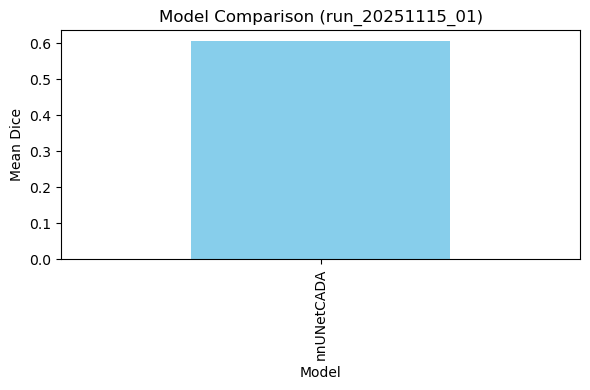

In [ ]:
# plt.figure(figsize=(6,4))
# df.groupby("Model")["Dice"].mean().plot(kind="bar", color="skyblue")
# plt.ylabel("Mean Dice")
# plt.title(f"Model Comparison ({run_name})")
# plt.tight_layout()
# plt.show()


## Visualisierung der Segmentationen für eine Stichprobe von Dateien

In [ ]:
def visualize_segmentations(model_name, run_name, gt_dir=GT_DIR, base_pred_dir=PRED_DIR, n_samples=3):
    """
    Zeigt zufällig n_samples Segmentierungen (GT vs. Prediction vs. Overlay)
    für ein Modell aus dem aktuellen Lauf an.
    """
    pred_dir = os.path.join(base_pred_dir, f"{model_name}_{run_name}")
    if not os.path.exists(pred_dir):
        print(f"⚠️ Kein Ordner gefunden für {model_name} ({pred_dir})")
        return

    all_preds = [f for f in os.listdir(pred_dir) if f.endswith(".nii.gz")]
    if not all_preds:
        print(f"⚠️ Keine Prediction-Dateien in {pred_dir} gefunden.")
        return

    np.random.shuffle(all_preds)
    samples = all_preds[:n_samples]

    print(f"\n🎨 Zeige {n_samples} Stichproben aus {model_name}_{run_name} ...")

    for fname in samples:
        # Ground truth finden
        base = get_base_name(fname)
        gt_candidates = [f for f in os.listdir(gt_dir)
                         if f.startswith(base) and (f.endswith(".nii.gz") or f.endswith(".nii"))]

        if not gt_candidates:
            print(f"⚠️ Keine GT für {fname}, überspringe.")
            continue

        gt_path = os.path.join(gt_dir, gt_candidates[0])
        pred_path = os.path.join(pred_dir, fname)

        # Laden
        gt = nib.load(gt_path).get_fdata().astype(np.uint8)
        pred = nib.load(pred_path).get_fdata().astype(np.uint8)
        
        # # --- Shape & Spacing ---
        # gt_shape, pred_shape = gt.shape, pred.shape
        # gt_spacing = gt_nii.header.get_zooms()
        # pred_spacing = pred_nii.header.get_zooms()

        # print(f"\n🩻 {fname}")
        # print(f"   GT-Shape:    {gt_shape} | Spacing: {np.round(gt_spacing, 3)} mm")
        # print(f"   Pred-Shape:  {pred_shape} | Spacing: {np.round(pred_spacing, 3)} mm")

        # Slice mit maximaler Aktivität (wo GT oder Pred etwas hat)
        z_active = np.argmax(np.sum(gt + pred, axis=(0, 1)))
        print(f"🩻 {fname}: Slice mit maximaler Aktivität = {z_active}")

        # Overlay erzeugen
        overlay = np.zeros((*pred[:, :, z_active].shape, 3))
        overlay[..., 0] = gt[:, :, z_active].T   # rot = GT
        overlay[..., 2] = pred[:, :, z_active].T # blau = Pred

        # Plot
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(gt[:, :, z_active].T, cmap="Reds", origin="lower")
        plt.title("Ground Truth")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(pred[:, :, z_active].T, cmap="Blues", origin="lower")
        plt.title("Prediction")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(overlay, origin="lower")
        plt.title("Overlay (rot=GT, blau=Pred)")
        plt.axis("off")

        plt.suptitle(f"{model_name} – {fname}", fontsize=12)
        plt.tight_layout()
        plt.show()


🎨 Zeige 2 Stichproben aus nnUNetCADA_run_20251115_01 ...
🩻 C0008_LPS.nii.gz: Slice mit maximaler Aktivität = 108


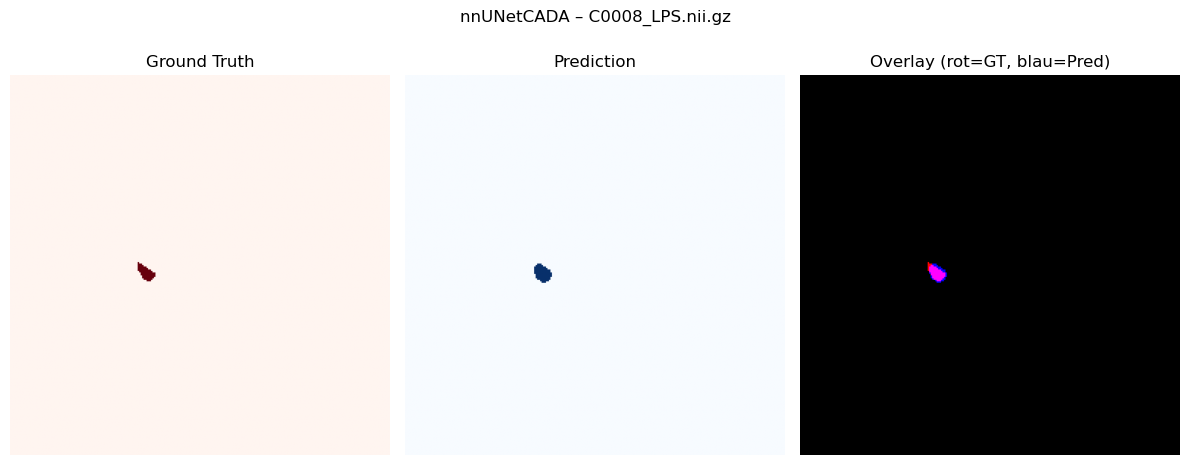

🩻 C0038_LPS.nii.gz: Slice mit maximaler Aktivität = 114


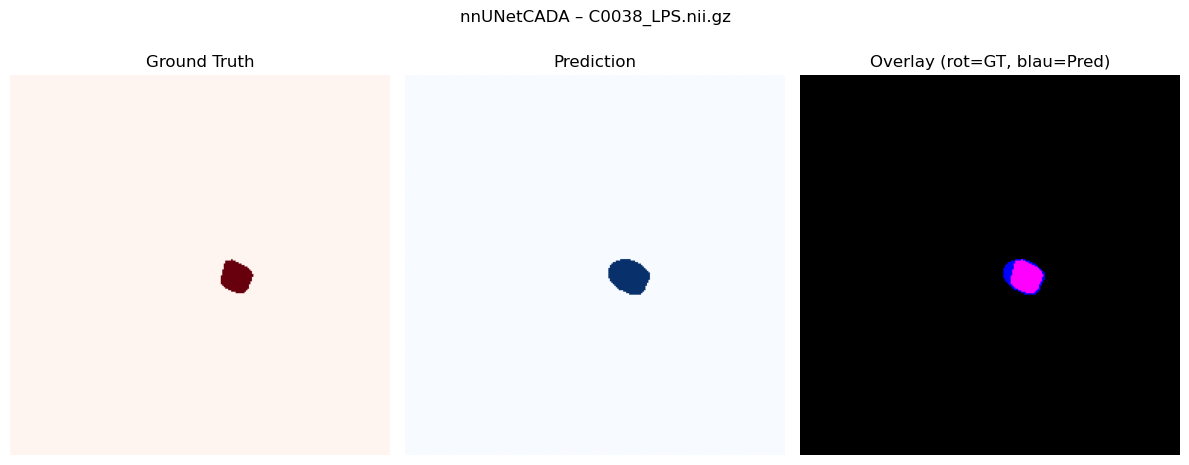

In [ ]:
for model in MODEL_NAMES:
    visualize_segmentations(model, run_name, n_samples=2)